# I) Summary

- The paper [Very Deep Convolutional Networks for Large-Scale Image Recognition][vgg-paper] introduces a familly of ConvNets called VGGNet.

- During ILSVLC-2014, they achieved 2nd place at the classification task (top-5 test error = 7.3%)

- They demonstrated that depth is beneficial for the classification accuracy.

- In spite of its large depth, the number of weights is not greater than number of weights in a more shallow net with larger conv.

- One conclusion that VGGNet gave us was that if we have many back to back convolutional layers then we don’t need a larger filter in the initial layers, we could have small filters.

- Therefore, VGGNet uses a smaller filter size (3x3 stride 1) contrary to AlexNet (11x11 with stride 4) and ZFNet (7x7 stride 2).

--- 

VGG architecture:

- Input size 224x224x3 (RGB image).
- Preprocessing done by substracting training set RGB mean.
- Filters size 3x3.
- Convolutional layers:
    - stride 1.
    - padding 1 (3x3 conv layers).
    - ReLU or LRN for one of the config.  
    - followed by 5 max pooling layers (not all of them).
        - 2x2 window.
        - stride = 2.
- Fully-connected layers:
    - 1st: 4096 (ReLU).
    - 2nd: 4096 (ReLU).
    - 3rd: 100 (Softmax).
 

VGGNet configurations:

- VGG-11
- VGG-11 (LRN)
- VGG-13
- VGG-16 (Conv1)
- VGG-16
- VGG-19 

![figure-1]

We are going to focus on VGG-16. Here is its architecture:

![legend-model]
![vgg16]
![vgg16-extension]

[vgg-paper]: https://arxiv.org/pdf/1409.1556.pdf
[figure-1]: https://cdn.discordapp.com/attachments/676833120053493770/688707846220939294/unknown.png
[legend-model]: https://cdn.discordapp.com/attachments/676833120053493770/690676447336988832/legend.png
[vgg16]: https://cdn.discordapp.com/attachments/676833120053493770/690522014519263292/unknown.png
[vgg16-extension]: https://cdn.discordapp.com/attachments/676833120053493770/690522930337284137/unknown.png

# II) Implementation

We are going to implement VGG-16.

In [44]:
from utils import *
from classes import class_names
from collections import OrderedDict
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2
import urllib.request
import torch.nn as nn
import torchvision.transforms as transforms
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

## a) Architecture build

In [45]:
class Vgg16(nn.Module):
    
    def __init__(self):
        super(Vgg16, self).__init__()
        
        # CONV PART.
        self.features = nn.Sequential(OrderedDict([
            ('block1-conv1', nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)),
            ('block1-act1', nn.ReLU()),
            ('block1-conv2', nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)),
            ('block1-act2', nn.ReLU()),
            
            ('pool1', nn.MaxPool2d(kernel_size=2, stride=2)),
            
            ('block2-conv1', nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)),
            ('block2-act1', nn.ReLU()),
            ('block2-conv2', nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)),
            ('block2-act2', nn.ReLU()),
            
            ('pool2', nn.MaxPool2d(kernel_size=2, stride=2)),
            
            ('block3-conv1', nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)),
            ('block3-act1', nn.ReLU()),
            ('block3-conv2', nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)),
            ('block3-act2', nn.ReLU()),
            ('block3-conv3', nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)),
            ('block3-act3', nn.ReLU()),
            
            ('pool3', nn.MaxPool2d(kernel_size=2, stride=2)),
            
            ('block4-conv1', nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)),
            ('block4-act1', nn.ReLU()),
            ('block4-conv2', nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)),
            ('block4-act2', nn.ReLU()),
            ('block4-conv3', nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)),
            ('block4-act3', nn.ReLU()),
            
            ('pool4', nn.MaxPool2d(kernel_size=2, stride=2)),
            
            ('block5-conv1', nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)),
            ('block5-act1', nn.ReLU()),
            ('block5-conv2', nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)),
            ('block5-act2', nn.ReLU()),
            ('block5-conv3', nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)),
            ('block5-act3', nn.ReLU()),
            
            ('pool5', nn.MaxPool2d(kernel_size=2, stride=2))
        ]))
        
        # FC PART.
        
        self.classifier = nn.Sequential(OrderedDict([
            ('fc6', nn.Linear(512 * 7 * 7, 4096)),
            ('act6', nn.ReLU()),
            ('fc7', nn.Linear(4096, 4096)),
            ('act7', nn.ReLU()),
            ('fc8', nn.Linear(4096, 1000))
        ]))
        
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [46]:
model = Vgg16()
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## b) Loading pretrained model

In [47]:
#Download pretrained model.
urllib.request.urlretrieve('https://download.pytorch.org/models/vgg16-397923af.pth', 'vgg16-397923af.pth')
    
# Load pretrained model parameters into our model.
load_model_with_diff_keys('vgg16-397923af.pth', model)

# Delete 'vgg16-397923af.pth'.
os.remove('vgg16-397923af.pth')

## c) Evaluating

In [48]:
# Create a dataset.

class CustomDataset(Dataset):
    
    def __init__(self, transform = None):
        
        self.transform = transform
        self.imgs = []
        self.imgsToDisplay = []
        
        current_dir = os.getcwd()
        image_dir = os.path.join(current_dir, 'img/')
        img_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')]
    
        for img in img_files:
            # Read image.
            img = cv2.imread(img)
            
            self.imgsToDisplay.append(img)
            
            # Apply transformations.
            if self.transform is not None:
                img = self.transform(img)
                
            self.imgs.append(img)
            
    def __getitem__(self, index):    
        return self.imgs[index]
        
    def __len__(self):
        return len(self.imgs)

In [49]:
# Apply preprocessing step on dataset.
transformations = transforms.Compose([transforms.ToPILImage(), 
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                           std = [0.229, 0.224, 0.225])
                                     ])

custom_dataset = CustomDataset(transform=transformations)
test_loader = DataLoader(dataset=custom_dataset,
                         batch_size=1)

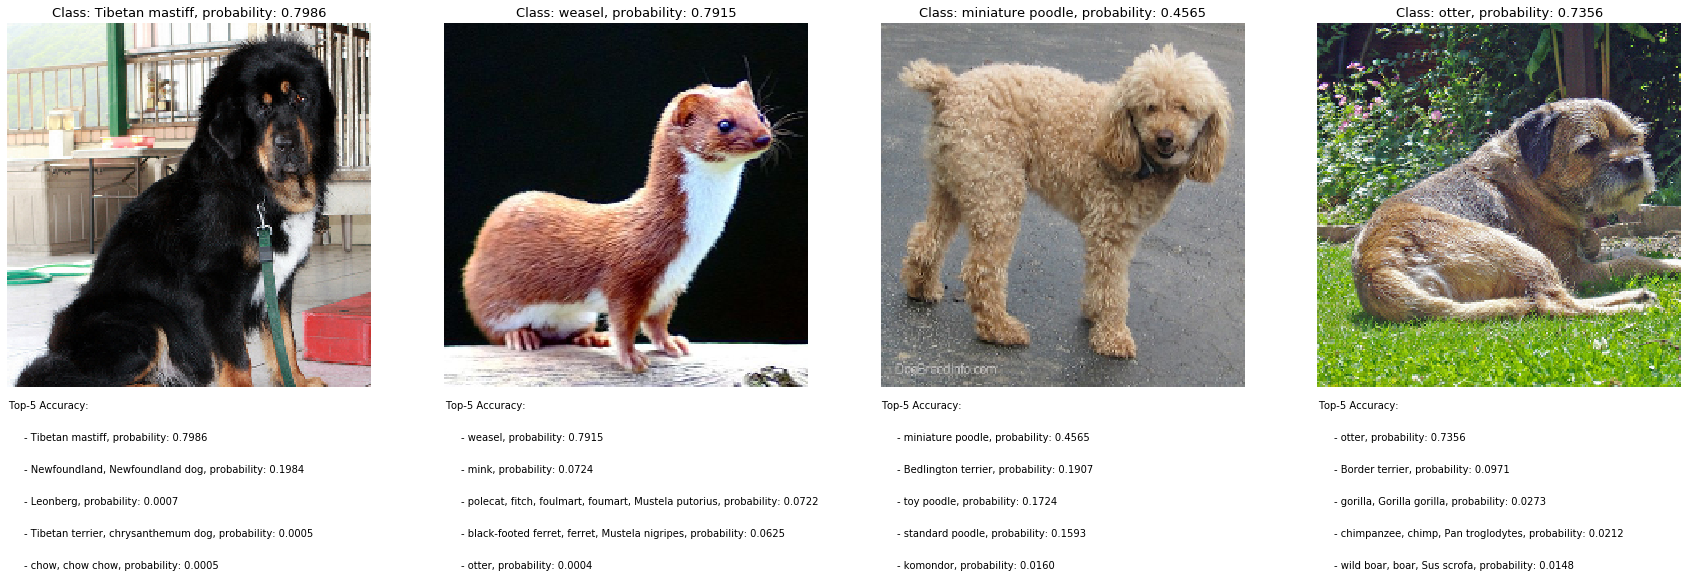

In [50]:
fig2 = plt.figure(figsize=(30,10))

model.eval()
with torch.no_grad():
    
    for i, image in enumerate(test_loader):
        probs = torch.nn.Softmax(dim=-1)(model(image))
        
        probability, class_idx = torch.max(probs, 1)
        class_name = class_names[class_idx]
         
        fig2.add_subplot(1,4,i+1)
        plt.imshow(cv2.cvtColor(custom_dataset.imgsToDisplay[i], cv2.COLOR_BGR2RGB))
        plt.title("Class: " + class_name + ", probability: %.4f" % probability, fontsize=13)
        plt.axis('off')

        plt.text(0, 240, 'Top-5 Accuracy:')
        x, y = 10, 260
        
        for idx in np.argsort(probs.numpy())[0][-5::][::-1]:
            s = '- {}, probability: {:.4f}'.format(class_names[idx], probs[0, idx])
            plt.text(x, y, s=s, fontsize=10)
            y += 20
        print()